         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  50.391781  female     168    62.0    110     80            1     1      0   
1  55.419178    male     156    85.0    140     90            3     1      0   
2  51.663014    male     165    64.0    130     70            3     1      0   
3  48.282192  female     169    82.0    150    100            1     1      0   
4  47.873973    male     156    56.0    100     60            1     1      0   

   alco  active  target  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4

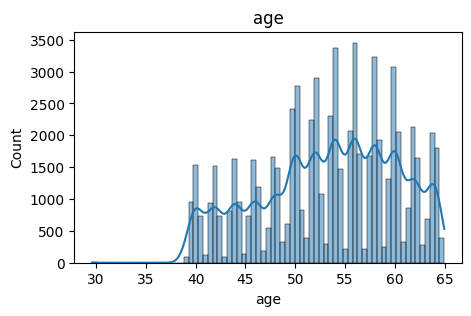

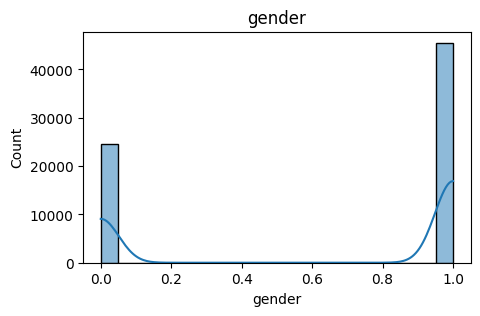

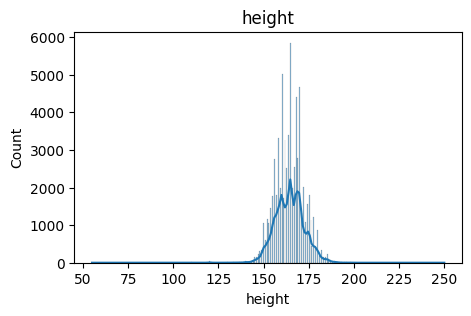

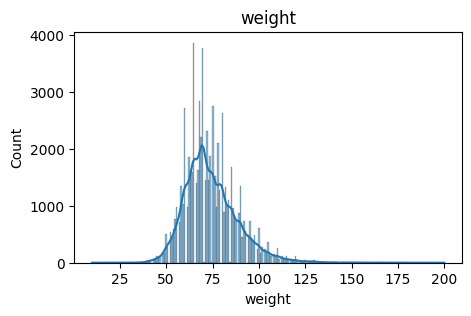

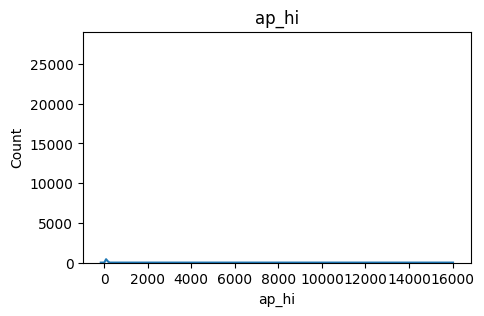

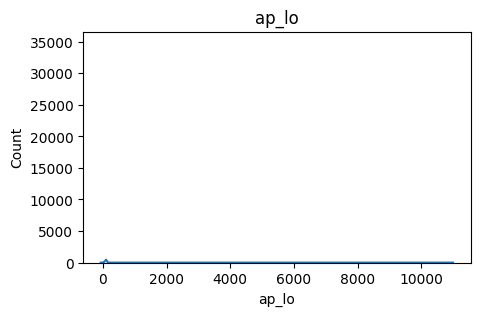

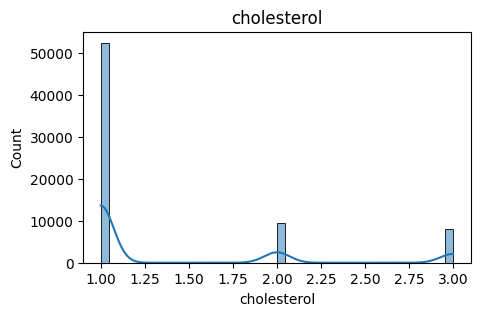

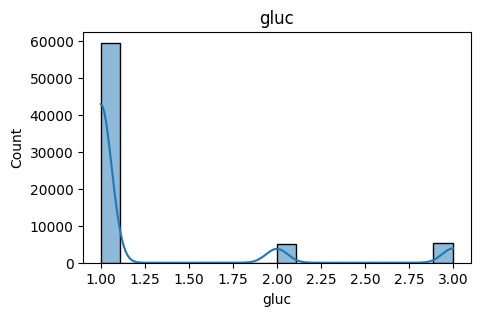

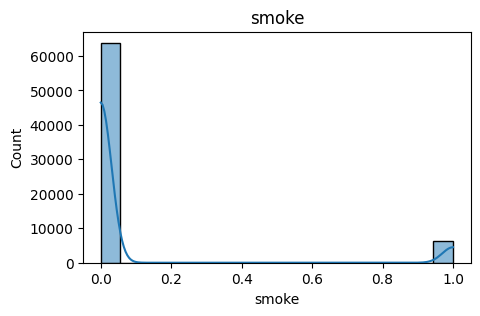

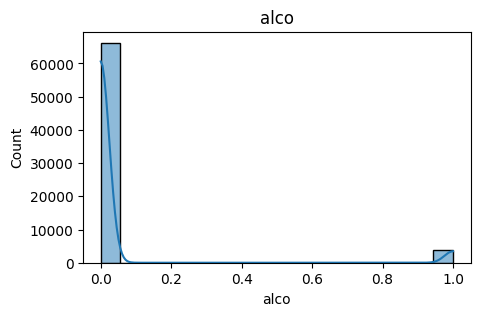

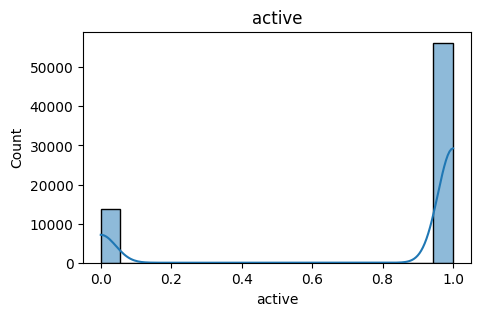

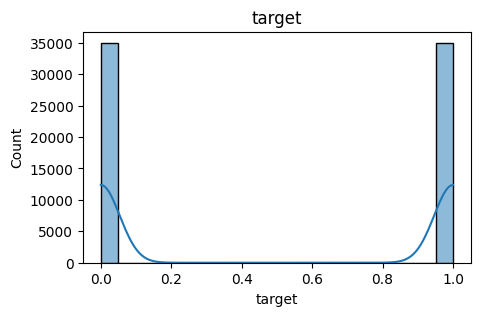

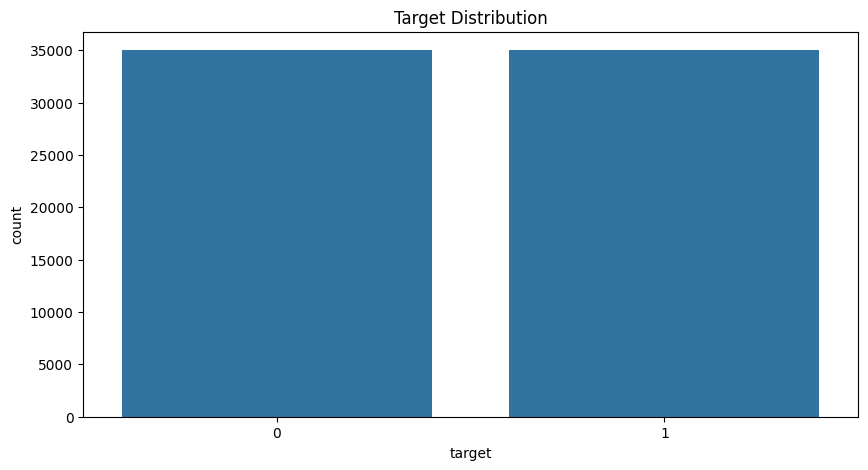

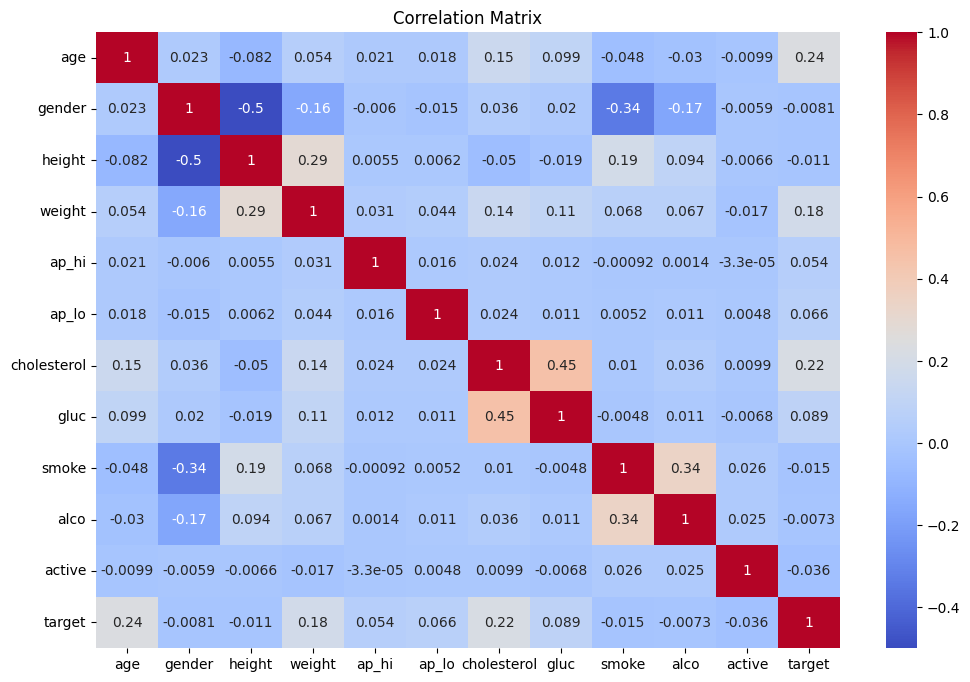


Logistic Regression Accuracy = 0.717047619047619
[[3958 1303]
 [1668 3571]]
              precision    recall  f1-score   support

           0       0.70      0.75      0.73      5261
           1       0.73      0.68      0.71      5239

    accuracy                           0.72     10500
   macro avg       0.72      0.72      0.72     10500
weighted avg       0.72      0.72      0.72     10500


SVM Accuracy = 0.7289523809523809
[[3966 1295]
 [1551 3688]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      5261
           1       0.74      0.70      0.72      5239

    accuracy                           0.73     10500
   macro avg       0.73      0.73      0.73     10500
weighted avg       0.73      0.73      0.73     10500


KNN Accuracy = 0.6466666666666666
[[3452 1809]
 [1901 3338]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      5261
           1       0.65      0.64   

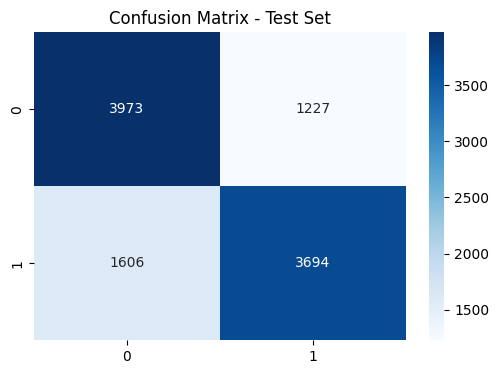

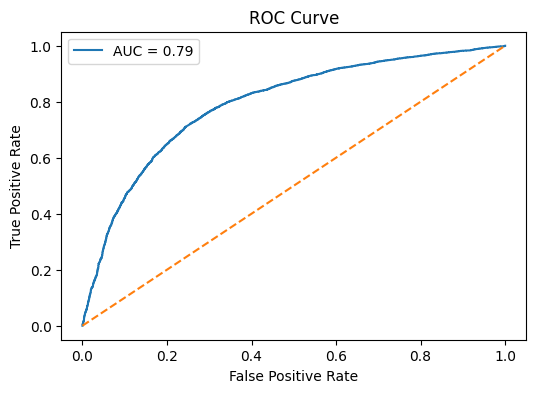


Example Prediction:
No Heart Disease
Example Prediction:
No Heart Disease


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Cardiovascular Disease Prediction Project [Major]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

#load dataset
df = pd.read_csv('/content/cardio_train (1).csv', sep=';', header=None, skiprows=1)

#assign column names
col_names = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'target']
df.columns = col_names

df = df.drop('id', axis=1)

#fix age aka in yrs
df['age'] = df['age'] / 365

#fix gender 0-f, 1-m
df['gender'] = df['gender'].replace({1: 1, 2: 0, 0: np.nan, 3: np.nan})
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

#display gender as male/female
df_display = df.copy()
df_display['gender'] = df_display['gender'].map({1: 'male', 0: 'female'})
print(df_display.head())

print(df.info())
print(df.describe())
print(df.isnull().sum())

# Handle missing values by dropping rows with NaNs
df.dropna(inplace=True)

#preprocessing
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#visualizations
for col in df.columns:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title('Target Distribution')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

results = {}
all_preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results[name] = acc
    all_preds[name] = preds
    print(f"\n{name} Accuracy = {acc}")
    print(confusion_matrix(y_val, preds))
    print(classification_report(y_val, preds))

#accuracy summary table
print("\nModel Accuracy Summary:")
for m, a in results.items():
    print(m, "=", a)

#best model selection(4th try)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print("Best Model:", best_model_name)

#test set evaluation
final_preds = best_model.predict(X_test)
print("\nFinal Test Classification Report:")
print(classification_report(y_test, final_preds))

#confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

#ROC Curve
probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#feature importance(RF only)
if best_model_name == 'Random Forest':
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), X.columns[sorted_idx], rotation=90)
    plt.title('Feature Importance')
    plt.show()

#save both model and scaler
joblib.dump(best_model, 'best_heart_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

#perdiction function
def predict_heart_disease(data_list):
    arr = np.array(data_list).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    result = best_model.predict(arr_scaled)[0]
    return "Heart Disease Present" if result == 1 else "No Heart Disease"

print("\nExample Prediction:")
print(predict_heart_disease(X.iloc[0].tolist()))

#FINAL PREDICTION FUNCTION

import pandas as pd

def predict_risk(age, gender, height, weight, ap_hi, ap_lo,
                 cholesterol, gluc, smoke, alco, active):

    #convert gender text to number
    gender = 1 if str(gender).lower() == "male" else 0

    #build input dataframe with correct feature names
    input_data = pd.DataFrame([{
        'age': age,
        'gender': gender,
        'height': height,
        'weight': weight,
        'ap_hi': ap_hi,
        'ap_lo': ap_lo,
        'cholesterol': cholesterol,
        'gluc': gluc,
        'smoke': smoke,
        'alco': alco,
        'active': active
    }])

    #scale using same scaler as training
    input_scaled = scaler.transform(input_data)

    #predict
    pred = best_model.predict(input_scaled)[0] # Changed model to best_model here to fix the prediction function

    return "Heart Disease" if pred == 1 else "No Heart Disease"


#TEST PREDICTION OUTPUT

print("Example Prediction:")

result = predict_risk(
    age=47,
    gender="female",
    height=165,
    weight=70,
    ap_hi=120,
    ap_lo=80,
    cholesterol=1,
    gluc=1,
    smoke=0,
    alco=0,
    active=1
)

print(result)
